In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scaling_lib.ftutils_torch as ftutils
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import unitary_group

In [2]:
from scaling_lib.split_step_solver import BPMSplitStepSolver
from scaling_lib.waveguide import Waveguide
from scaling_lib.helpers import smoothen1d, add_absorbing_boundary, timestring, L2, has_converged
from scaling_lib.mode_solver import solve_modes
from scaling_lib import pnn_utils 

## Helper functions

In [3]:
class TDwgNet(nn.Module):
    def __init__(self, solver, wg, delta_n_val, modes, device):
        super(TDwgNet, self).__init__()
        self.device = device
        
        mod = 0.5*torch.ones([wg.Nz, wg.Nx], requires_grad=True, dtype=torch.float32).to(self.device)
        self.mod = pnn_utils.Parameter(mod, limits=[0.05, 0.95]) 
        self.delta_n_val = delta_n_val
        
        self.input_modes = modes.to(dtype=torch.complex64).to(self.device)
        self.output_modes = modes.to(dtype=torch.complex64).to(self.device)
        
        self.wg = wg
        self.solver = solver
        
    def forward(self, x, monitor = False):
        mod = self.mod
        mod = mod.clip(0., 1.)

        inputs = x.to(self.device) @ self.input_modes
        
        delta_n = self.wg.background_delta_n + self.delta_n_val*mod
        output_beams = self.solver.run_simulation(inputs, delta_n, monitor)
        
        a_out = output_beams@self.output_modes.T*dx
        return a_out

In [4]:
def run_training_loop(tdwg_pnn, U_target, iterations, lr, batch_size, device, gamma=0.99, print_interval=1, save_model = False):
    optimizer = optim.Adam(tdwg_pnn.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    U_target = U_target.to(device)
    loss_list = []
    
    n = len(tdwg_pnn.input_modes)  # length of the original vector
    indices = np.arange(n)
    batch_indices = np.array_split(indices, np.ceil(n / batch_size))  # Split into subvectors

    tdwg_pnn.train()
    for i in range(iterations):
        optimizer.zero_grad()

        for indices in batch_indices:
            U_num = tdwg_pnn.forward(torch.eye(n, dtype = torch.complex64)[indices])
            l_objective = L2(U_target[indices], U_num)
    
            l_lagrange = pnn_utils.lagrangian(tdwg_pnn, lag_amp = 1, factor = 20)
            l = l_objective + l_lagrange 
            l.backward()
            
        optimizer.step()
        scheduler.step()
        loss_list.append(l.detach().cpu().data)

        if i % print_interval == 0:
            print(timestring() + f"--Iteration: {i}, Loss: {l.detach().cpu().data:.5f}")
        if has_converged(loss_list, std_threshold=0.001):
            print(timestring() + f"Converged at iteration: {i}, Loss: {l.detach().cpu().data:.5f}")
            break
        if save_model:
            torch.save({
                    'epoch': i,
                    'model_state_dict': tdwg_pnn.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'loss': l,
                }, 'saved_model.pt')
            
    return loss_list

## Setting up waveguide

In [5]:
Nmodes = 100
device = "cuda" if torch.cuda.is_available() else "cpu"

# waveguide parameters
λ0 = 1.55 # free-space wavelength, all lengths are in um
k0 = 2*np.pi/λ0

# training parameters
seed = 1 # seed used when sampling random unitary
iterations = 500 # number of training epochs
lr = 0.025

# waveguide parameters
neff = 3.0 # effective index of slab mode
dn_wg = 0.1 # step-index change
delta_n_val = 0.005 # maximal programmable refractive index change
Lz = 7000.0 # length of device in propagation-direction

NA = np.sqrt(2*neff*dn_wg) # approximate numerical aperture

d_wg = (1.5 * Nmodes-1)*λ0 / 2 / NA # make waveguide sufficiently wide
Λz = λ0 / dn_wg # expected necessary resolution
Λx = λ0 / 2 / NA # expected necessary resolution

# x-axis
Lx = d_wg + 40 # width of simulation area (transverse dimension)
Nx = Lx / Λx * 10 # 10 steps per smallest resolution feature
Nx = int(2**np.ceil(np.log2(Nx))) # make Nx a power of 2
dx = Lx/(Nx-1) # stepsize in transverse dimension
x_axis = ftutils.ft_t_axis(Nx, dx)

# z-axis
Nz = int(Lz / Λz * 5/2)*2 # 5 steps per smallest resolution feature (even integer)
z_axis = np.linspace(0, Lz, Nz)
dz = z_axis[1]-z_axis[0]

In [6]:
print(f'N_modes = {Nmodes}')
print(f'dn_wg = {dn_wg}')
print(f'dn_prog = {delta_n_val}')
print(f'Lx = {d_wg:.0f}')
print(f'Lz = {Lz:.0f}')

print(f'NA = {NA:.2f}')
print(f'Λx={Λx:.2f}, Λz={Λz:.2f}, Nz={Nz}')
print(f'dx={dx:.2f}, dz={dz:.2f}, Nx={Nx}')

N_modes = 100
dn_wg = 0.1
dn_prog = 0.005
Lx = 149
Lz = 7000
NA = 0.77
Λx=1.00, Λz=15.50, Nz=2258
dx=0.09, dz=3.10, Nx=2048


In [7]:
# Define the background delta n of the multimode waveguide
background_delta_n = torch.zeros(Nx, dtype = torch.complex64)
background_delta_n[torch.abs(x_axis)<d_wg/2] = dn_wg
background_delta_n = smoothen1d(x_axis, background_delta_n, 3*λ0)
background_delta_n = add_absorbing_boundary(x_axis, background_delta_n, k0)
# The waveguide class is just a convenient way of storing all parameters associated with the waveguide
# It doesn't do anything beyond that
wg = Waveguide(neff, x_axis, z_axis, background_delta_n, device = device)

In [8]:
# Now we find the first N TE modes and their propagation constants (betas)
betas, modes = solve_modes(wg.x_axis.numpy(), neff, k0, background_delta_n.numpy(), Nmodes, fresnel = True)
betas = torch.from_numpy(betas)
modes = torch.from_numpy(modes)

# save these in case we want to reuse them later
torch.save(betas, f'betas_N={Nmodes}.pt')
torch.save(modes, f'modes_N={Nmodes}.pt')

In [9]:
betas = torch.load(f'betas_N={Nmodes}.pt', weights_only=True)
modes = torch.load(f'modes_N={Nmodes}.pt', weights_only=True)

In [10]:
# normalize modes as scipy's mode solver fails to normalize properly for very high N
norm_factors = modes.abs().square().sum(-1)*dx
modes /= torch.sqrt(norm_factors)[None,:].T

(0.0, 0.06)

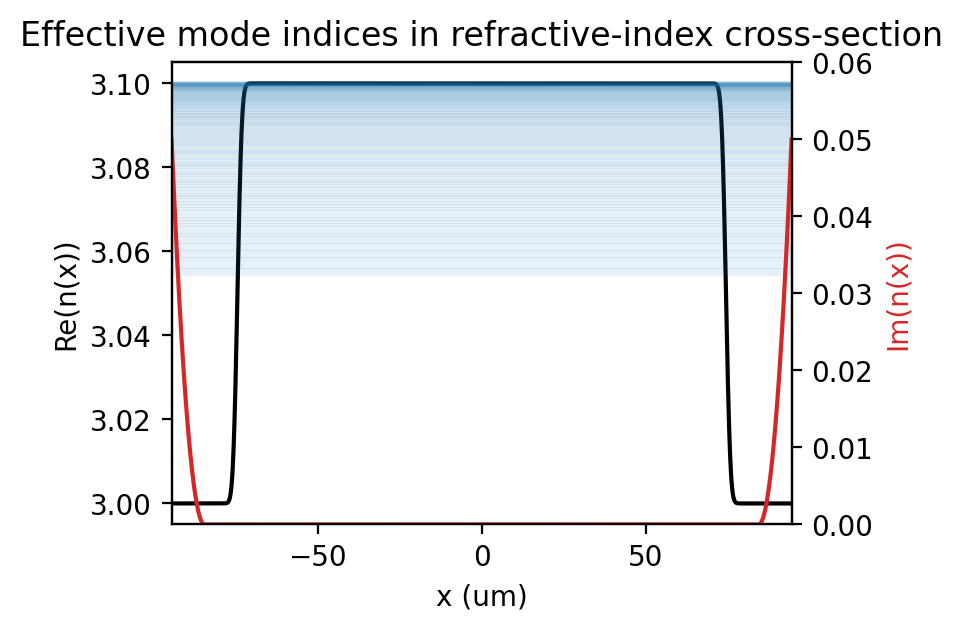

In [11]:
plt.figure(figsize = (4,3), dpi = 200)

plt.title('Effective mode indices in refractive-index cross-section')
plt.plot(x_axis, background_delta_n.real + neff, c='k')
plt.xlim(x_axis.min(), x_axis.max())
plt.ylabel('Re(n(x))')
plt.xlabel('x (um)')
for beta in betas:
    plt.axhline(beta/k0, c = 'tab:blue', alpha = 0.1)
plt.twinx()
plt.plot(x_axis, background_delta_n.imag, c='tab:red')
plt.ylabel('Im(n(x))', color ='tab:red')
plt.ylim(0,0.06)

Text(0.5, 1.0, 'First 8 waveguide modes')

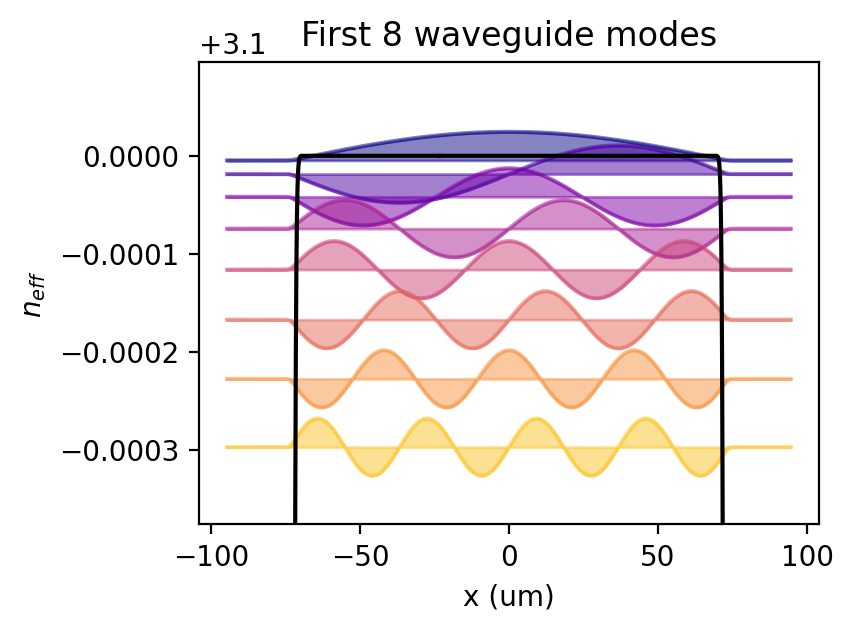

In [12]:
plt.figure(figsize = (4,3), dpi = 200)

for ind_mode, (mode, beta) in enumerate(zip(modes[:8], betas[:8])):
    plt.fill_between(x_axis, beta/k0, mode/4e3 + beta/k0, label = f'$TE_{ind_mode}$', color = cm.plasma(ind_mode/8), alpha = 0.5)
    plt.plot(x_axis, mode/4e3 + beta/k0, color = cm.plasma(ind_mode/8), alpha = 0.5)
plt.plot(x_axis, neff + background_delta_n.real, c='k')

plt.ylim(betas[8]/k0, betas[0]/k0 + 1e-4)
plt.xlabel('x (um)')
plt.ylabel(r'$n_{eff}$')
plt.title('First 8 waveguide modes')

In [13]:
# Set up the split step solver which will integrate the PDE
bpmsolver = BPMSplitStepSolver(x_axis, z_axis, neff)

U_target = unitary_group.rvs(Nmodes, random_state=seed)
U_target = torch.tensor(U_target, device = device)

tdwg_pnn = TDwgNet(bpmsolver, wg, delta_n_val, modes, device)

## Train

2025-09-23--12-09-27--Iteration: 0, Loss: 0.99994
2025-09-23--12-09-32--Iteration: 5, Loss: 0.57568
2025-09-23--12-09-36--Iteration: 10, Loss: 0.32910
2025-09-23--12-09-40--Iteration: 15, Loss: 0.20869
2025-09-23--12-09-44--Iteration: 20, Loss: 0.14020
2025-09-23--12-09-48--Iteration: 25, Loss: 0.09598
2025-09-23--12-09-52--Iteration: 30, Loss: 0.05674
2025-09-23--12-09-56--Iteration: 35, Loss: 0.02596
2025-09-23--12-10-00--Iteration: 40, Loss: 0.01559
2025-09-23--12-10-04--Iteration: 45, Loss: 0.00984
2025-09-23--12-10-09--Iteration: 50, Loss: 0.00543
2025-09-23--12-10-13--Iteration: 55, Loss: 0.00402
2025-09-23--12-10-17--Iteration: 60, Loss: 0.00199
2025-09-23--12-10-21--Iteration: 65, Loss: 0.00147
2025-09-23--12-10-25--Iteration: 70, Loss: 0.00096
2025-09-23--12-10-29--Iteration: 75, Loss: 0.00069
2025-09-23--12-10-33--Iteration: 80, Loss: 0.00059
2025-09-23--12-10-37--Iteration: 85, Loss: 0.00044
2025-09-23--12-10-41--Iteration: 90, Loss: 0.00040
2025-09-23--12-10-45--Iteration: 

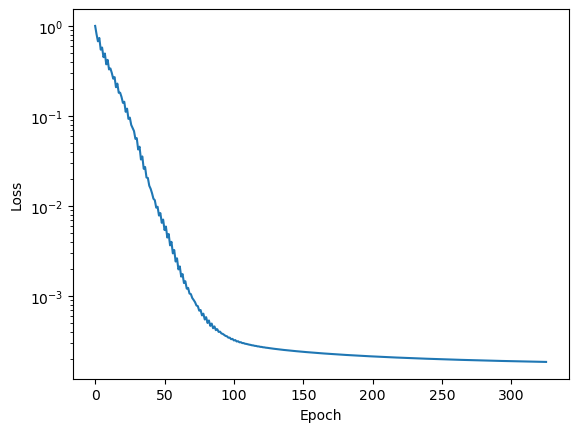

In [14]:
torch.cuda.empty_cache()
loss_list = run_training_loop(tdwg_pnn, U_target, iterations, lr, batch_size = 100, device = device, print_interval=5, gamma = 0.995, save_model=True)

with torch.no_grad():
    U_num_inv = tdwg_pnn(torch.eye(Nmodes, dtype = torch.complex64))

avg_error_inv = torch.mean(torch.abs(U_num_inv-U_target))/torch.mean(torch.abs(U_target)) * 100
print(lr)
print(f"Average error for inverse design: {avg_error_inv:.2f}%")

torch.cuda.empty_cache()

plt.plot(loss_list)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Evaluate training

In [15]:
with torch.no_grad():
    U_num_inv = tdwg_pnn.forward(torch.eye(Nmodes, dtype = torch.complex64), monitor = False)

In [16]:
avg_error_inv = torch.mean(torch.abs(U_num_inv-U_target))/torch.mean(torch.abs(U_target)) * 100
print(f"Average error for inverse design: {avg_error_inv:.2f}%")

Average error for inverse design: 0.69%


#### Plot inverse design results

In [26]:
def plot_delta_n(z_axis, x_axis, delta_n, vmax):
    figsize_deltan = (2*3, 2*1.5*3/5)
    fig_main, ax = plt.subplots(figsize=figsize_deltan, dpi=200)
    img = plt.pcolormesh(z_axis/1000, x_axis, np.real(delta_n.T), cmap="coolwarm", vmax=vmax, vmin=0)
    plt.ylim(x_axis.min(), x_axis.max())
    plt.xlabel("z (mm)")
    plt.ylabel("x (um)")
    plt.title(r"$\Delta n(x, z)$")
    plt.colorbar()
    
    plt.show()

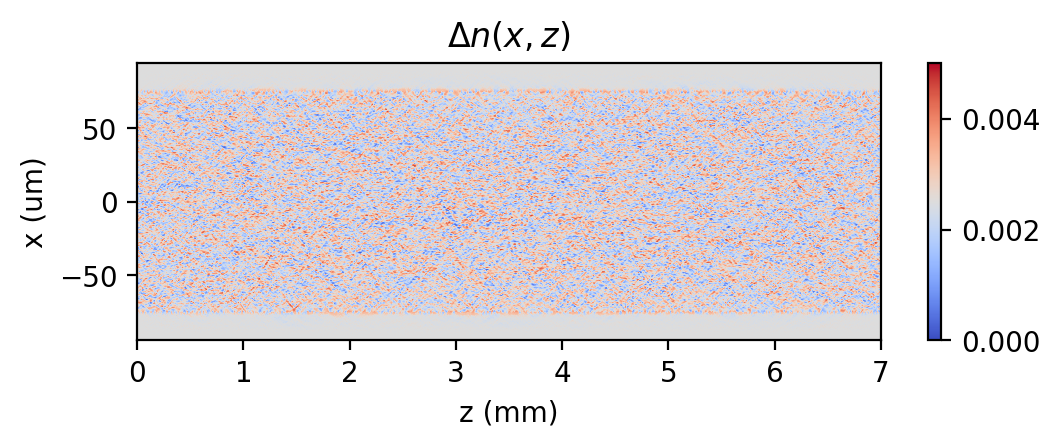

In [28]:
delta_n_inv = delta_n_val*(torch.clip(tdwg_pnn.mod.cpu().detach(), 0., 1.))
plot_delta_n(wg.z_axis, wg.x_axis, delta_n_inv, delta_n_val)

In [19]:
def plot_unitary(U, vmax, title, colorbar_flag=True):
    figsize_U = (2*1.3, 2*1.3)
    
    # Plot main figure
    fig_main, ax = plt.subplots(figsize=figsize_U, dpi=200)
    img = plt.imshow(np.abs(U), cmap="bone_r", vmax=vmax)
    plt.title(title)
    # plt.xticks([0, 2, 4, 6, 8])
    # plt.xlim(0, 20)
    # plt.ylim(20, 0)
    
    if colorbar_flag:
        # Create a separate figure for the colorbar
        fig_cbar = plt.figure(figsize=(0.1, figsize_U[1]))
        cbar = plt.colorbar(img, cax=plt.gca())
    
    # Display figures
    plt.show()

In [20]:
vmax = U_target.abs().max()

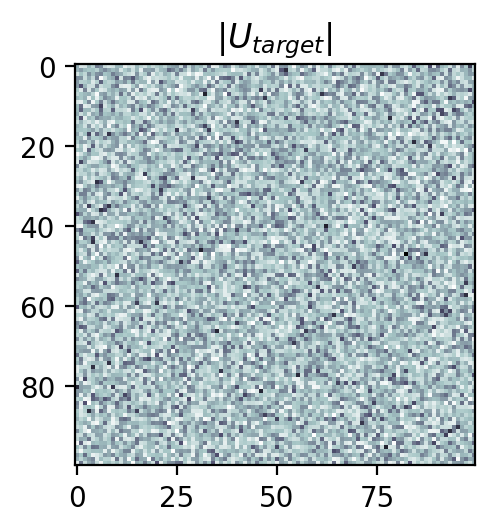

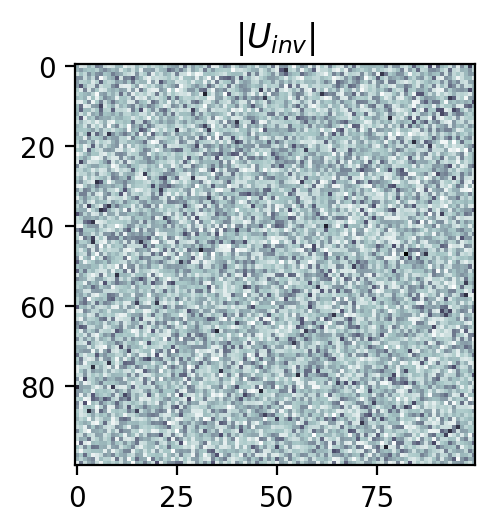

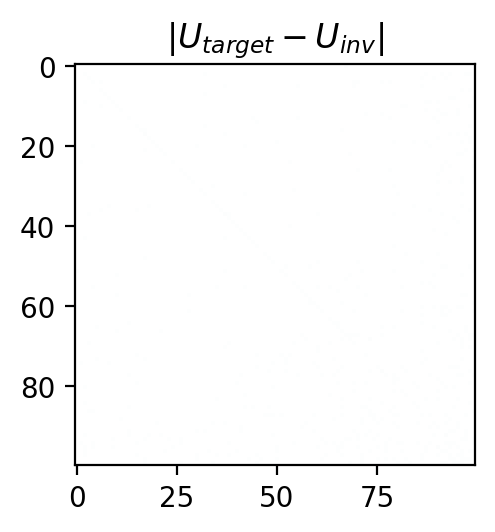

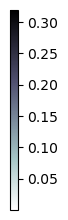

In [21]:
plot_unitary(U_target.cpu(), vmax, r"$|U_{target}|$", colorbar_flag=False)
plot_unitary(U_num_inv.cpu(), vmax, r"$|U_{inv}|$", colorbar_flag=False)
plot_unitary(torch.abs(U_num_inv-U_target).cpu(), vmax, r"$|U_{target}-U_{inv}|$", colorbar_flag=True)

#### Plot wave propagation

In [22]:
torch.cuda.empty_cache()
tdwg_pnn.solver.Ncom = 2 # plot only every other point to make plotting faster

with torch.no_grad():
    U_num_inv = tdwg_pnn.forward(torch.eye(Nmodes, dtype = torch.complex64)[[0, 1, 2]], monitor = True)

In [23]:
def plot_intensity(z_axis, x_axis, Imat_x):
    figsize_deltan = (2*3, 2*1.5*3/5)
    fig_main, ax = plt.subplots(figsize=figsize_deltan, dpi=200)
    img = plt.pcolormesh(z_axis/1000, x_axis, Imat_x, cmap="Reds")
    plt.ylim(x_axis.min(), x_axis.max())
    plt.xlabel("z (mm)")
    plt.ylabel("x (um)")
    plt.title(r"$I(x, z)$")
    plt.colorbar()

    plt.show()

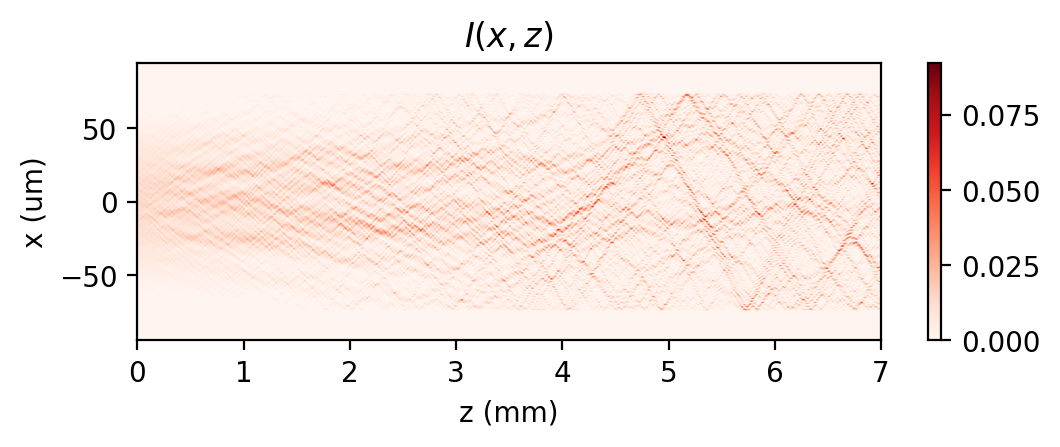

In [24]:
ind =  0
Emat_x = tdwg_pnn.solver.Emat_x[:,ind].cpu().detach()
Imat_x = Emat_x.abs().square()
z_list = z_axis[::tdwg_pnn.solver.Ncom]
plot_intensity(z_list, x_axis, Imat_x.T)

In [25]:
# blueprint code to load model
checkpoint = torch.load('saved_model.pt', weights_only=True)
tdwg_pnn.load_state_dict(checkpoint['model_state_dict'])
print(f'Saved at epoch {checkpoint['epoch']} with loss {checkpoint['loss']}')
tdwg_pnn.eval()
# tdwg_pnn.train()

Saved at epoch 324 with loss 0.00018686052668644585


TDwgNet()